In [107]:
import sys
sys.path.append('/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/')
from global_variables import *

In [108]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np

In [109]:
def capitalize_words(text):
    
    return ' '.join(word.capitalize() for word in text.split())


def is_in_sub(tissue, sub_dict):

    key_ix = np.array([key in tissue for key in sub_dict.keys()]).flatten()
    is_in = key_ix.any()

    if is_in:
        tissue = np.array(list(sub_dict.keys()))[key_ix]
        return is_in, tissue
    else:
        return is_in, np.nan


def get_parent_tissues_dict(lst_tissues, oncotree_df):

    tissue_parent_dict = {}
    upper_ttypes = ["SOLID", "BOWEL", "OTHER", "CANCER", "NON_SOLID", np.nan]
    for tissue in lst_tissues:
        parent = tissue
        while parent not in upper_ttypes:
            if parent not in upper_ttypes:
                if parent not in upper_ttypes:
                    tissue_parent_dict[tissue] = parent
                    parent = oncotree_df[oncotree_df["ID"] == parent].PARENT.values
                    if len(parent) == 0:
                        parent = "OTHER"
                    else:
                        parent = parent[0]

    return tissue_parent_dict

In [110]:
datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)
cohort_release_df = pd.read_csv(f"{input_path}/cohorts_release.tsv", sep="\t")

oncotree_df = pd.read_csv(f"{datasets}/input/cancer_202404/oncotree.tsv", sep="\t")
display(oncotree_df)

,ID,PARENT,NAMES
0,AA,SOFT_TISSUE,Aggressive Angiomyxoma
1,AASTR,DIFG,Anaplastic Astrocytoma
2,ABC,DLBCLNOS,Activated B-cell Type
3,ABL,AMLNOS,Acute Basophilic Leukemia
4,ACA,ADRENAL_GLAND,Adrenocortical Adenoma
...,...,...,...
883,WDLS,LIPO,Well-Differentiated Liposarcoma
884,WDTC,THYROID,Well-Differentiated Thyroid Cancer
885,WM,LPL,Waldenstrom Macroglobulinemia
886,WPSCC,PSCC,Warty Penile Squamous Cell Carcinoma


## Parse

In [111]:
# Soft tissue issue 
cohort_df.COHORT = cohort_df.COHORT.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
cohort_df.CANCER_TYPE = cohort_df.CANCER_TYPE.replace("SOFT_TISSUE", "SARC")
cohort_df.CANCER_TYPE = cohort_df.CANCER_TYPE.replace("SARCNOS", "SARC")
cohort_df.CANCER_TYPE.unique()

array(['BLCA', 'EGC', 'LMS', 'STAD', 'MEL', 'AML', 'HCC', 'UCEC', 'EPM',
       'COADREAD', 'GB', 'ANSC', 'RCC', 'OS', 'BCC', 'RMS', 'PRAD', 'ACC',
       'WDTC', 'ES', 'UTUC', 'GIST', 'LIPO', 'MBL', 'ANGS', 'GBC', 'ALL',
       'LUNG', 'BRCA', 'RBL', 'CLLSLL', 'BLADDER', 'SCLC', 'NSCLC',
       'STOMACH', 'SKCM', 'NETNOS', 'SARC', 'COAD', 'HNSC', 'SIC', 'CHOL',
       'ESCC', 'DLBCLNOS', 'GBM', 'HGGNOS', 'NBL', 'ESCA', 'CSCC', 'SKIN',
       'LUAD', 'CEAD', 'PLMESO', 'LGGNOS', 'PAAD', 'OVT', 'LUSC', 'SACA',
       'CESC', 'CCRCC', 'PANCREAS', 'ACYC', 'MT', 'PROSTATE', 'READ',
       'PCM', 'BL', 'VULVA', 'PAST', 'ATRT', 'PANET', 'NHL', 'CHRCC',
       'MDS', 'NPC', 'LIHB', 'WT', 'MGCT', 'UCS', 'UM', 'THYM', 'PRCC',
       'PGNG'], dtype=object)

In [112]:
# Get organ for our cohorts
cohorts_tissue_parent_dict = get_parent_tissues_dict(cohort_df.CANCER_TYPE.unique(), oncotree_df)
cohorts_tissue_parent_dict["SARC"] = "SOFT_TISSUE"
cohorts_tissue_parent_dict["SOFT_TISSUE"] = "SOFT_TISSUE"
cohort_df["GENERAL_CANCER_TYPE"] = cohort_df.CANCER_TYPE.apply(lambda x: cohorts_tissue_parent_dict[x])
cohort_df["GENERAL_CANCER_TYPE"] = cohort_df["GENERAL_CANCER_TYPE"].str.replace("SOFT_TISSUE", "SARC")
cohort_df

,COHORT,CANCER_TYPE,PLATFORM,MUTATIONS,SAMPLES,GENERAL_CANCER_TYPE
0,HARTWIG_WGS_BLCA_2023,BLCA,WGS,5017561,144,BLADDER
1,HARTWIG_WGS_EGC_2023,EGC,WGS,573540,21,STOMACH
2,HARTWIG_WGS_LMS_2023,LMS,WGS,339549,43,SARC
3,CBIOP_WGS_STAD_ONCOSG_2018,STAD,WGS,861309,147,STOMACH
4,CBIOP_WXS_CM_VALLEN_2018,MEL,WXS,132960,151,SKIN
...,...,...,...,...,...,...
210,TCGA_WXS_PRCC,PRCC,WXS,34566,276,KIDNEY
211,TCGA_WXS_PRAD,PRAD,WXS,34239,494,PROSTATE
212,TCGA_WXS_PLMESO,PLMESO,WXS,3980,82,PLEURA
213,TCGA_WXS_SARC,SARC,WXS,31484,234,SARC


In [113]:
# Merge full cancer name
cohort_release_df = cohort_release_df.rename(columns={"Cohort" : "COHORT", 
                                                      "Cancer type" : "CANCER_TYPE_FULL", 
                                                      "Age" : "AGE", 
                                                      "Type" : "TYPE"})
cohort_release_df.AGE = cohort_release_df.AGE.replace("AAdult", "Adult")
cohort_release_df.AGE = cohort_release_df.AGE.replace("PPediatric", "Pediatric")
cohort_release_df.TYPE = cohort_release_df.TYPE.replace("PPrimary", "Primary")
cohort_release_df.TYPE = cohort_release_df.TYPE.replace("RRelapse", "Relapse")
cohort_release_df.TYPE = cohort_release_df.TYPE.replace("MMetastasis", "Metastasis")
cohort_release_df = cohort_release_df.drop(columns=["Cancer drivers", "Samples", "Mutations"])

# Replace Soft Tissue with Sarcoma
cohort_release_df.COHORT = cohort_release_df.COHORT.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
cohort_release_df.CANCER_TYPE = cohort_release_df.CANCER_TYPE_FULL.replace("Soft Tissue", "Sarcoma")
cohort_release_df.CANCER_TYPE = cohort_release_df.CANCER_TYPE_FULL.replace("Sarcoma, NOS", "Sarcoma")

# Merge
cohort_df = cohort_df.merge(cohort_release_df, on="COHORT", how="left").drop(columns=["PLATFORM"])
cohort_df["GENERAL_CANCER_TYPE"] = cohort_df["GENERAL_CANCER_TYPE"].str.replace("_", " ")
cohort_df["GENERAL_CANCER_TYPE"] = cohort_df.GENERAL_CANCER_TYPE.str.replace("MYELOID", "MYELOID CELL TYPES")
cohort_df

/tmp/jobs/spellegrini/10392624/ipykernel_45523/4226841963.py:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  cohort_release_df.CANCER_TYPE = cohort_release_df.CANCER_TYPE_FULL.replace("Soft Tissue", "Sarcoma")


,COHORT,CANCER_TYPE,MUTATIONS,SAMPLES,GENERAL_CANCER_TYPE,CANCER_TYPE_FULL,AGE,TYPE
0,HARTWIG_WGS_BLCA_2023,BLCA,5017561,144,BLADDER,Bladder Urothelial Carcinoma,Adult,Metastasis
1,HARTWIG_WGS_EGC_2023,EGC,573540,21,STOMACH,Esophagogastric Adenocarcinoma,Adult,Metastasis
2,HARTWIG_WGS_LMS_2023,LMS,339549,43,SARC,Leiomyosarcoma,Adult,Metastasis
3,CBIOP_WGS_STAD_ONCOSG_2018,STAD,861309,147,STOMACH,Stomach Adenocarcinoma,Adult,Primary
4,CBIOP_WXS_CM_VALLEN_2018,MEL,132960,151,SKIN,Melanoma,Adult,Primary
...,...,...,...,...,...,...,...,...
210,TCGA_WXS_PRCC,PRCC,34566,276,KIDNEY,Papillary Renal Cell Carcinoma,Adult,Primary
211,TCGA_WXS_PRAD,PRAD,34239,494,PROSTATE,Prostate Adenocarcinoma,Adult,Primary
212,TCGA_WXS_PLMESO,PLMESO,3980,82,PLEURA,Pleural Mesothelioma,Adult,Primary
213,TCGA_WXS_SARC,SARC,31484,234,SARC,Soft Tissue,Adult,Primary


In [121]:
cohort_release_df

,CANCER_TYPE_FULL,COHORT,AGE,TYPE
0,Acute Lymphoblastic Leukemia,STJUDE_WGS_D_ALL_2018,Adult,Primary
1,Acute Lymphoblastic Leukemia,PEDCBIOP_WXS_BALL_PRY,Pediatric,Primary
2,Acute Lymphoblastic Leukemia,PEDCBIOP_WXS_BALL_REL,Pediatric,Relapse
3,Acute Lymphoblastic Leukemia,PEDCBIOP_WXS_TALL_REL,Pediatric,Relapse
4,Acute Lymphoblastic Leukemia,STJUDE_WGS_R_ALL_2018,Adult,Primary
...,...,...,...,...
266,Well-Differentiated Thyroid Cancer,ICGC_WXS_WDTC_THCA_CN_2019,Adult,Primary
267,Well-Differentiated Thyroid Cancer,PCAWG_WGS_THY_ADENOCA,Adult,Primary
268,Well-Differentiated Thyroid Cancer,HARTWIG_WGS_WDTC_2023,Adult,Metastasis
269,Wilms' Tumor,PEDCBIOP_WXS_WT_PRY,Pediatric,Primary


## Plot

In [147]:
dict_pad_cancer = {"RBL" : 1.49,
    
                "BCC" : 1.49,
                
                "PANET" : 1.47,
                "GIST" : 1.473,
                "PROSTATE" : 1.468,

                "UM" : 1.457,
                "UCS" : 1.463,
                "NPC" : 1.442,
    
                "CESC" : 1.453,
                   
                "RCC" : 1.42,
                "GB" : 1.42,
                "STOMACH" : 1.42,
                "ANGS" : 1.423,
                "HNSC" : 1.42,
                "COAD" : 1.42,
                
                "SIC" : 1.392,
                
                "SARC" : 1.395,
                
                "LMS" : 1.404,
                "PLMESO" : 1.403,
                
                "PGNG" : 1.385,
                "EPM" : 1.372,
                "CSCC" : 1.372}

dict_pad_organ = {"PANCREAS" : 1, 
                  "PLEURA" : 1.05,
                  "PNS" : 0.95,
                  
                  "THYROID" : 0.92,
                  "THYMUS" : 0.984,
                  "TESTIS" : 1.11,
                  
                  "SIC" : 0.97,
                  "SARC" : 1.03,
                  
                  "EYE" : 0.95,
                  "HEAD NECK" : 1.05,

                  "BILIARY TRACT" : 1.1, 
                  "ADRENAL GLAND"  : 0.92,
                  
                  "BLADDER" : 0.95,
                  "UTERUS" : 1.08,
                   
                  "MYELOID CELL TYPES" : 1.005,
                  "OVARY" : 1.03}

In [152]:
df.sort_values

,COHORT,CANCER_TYPE,MUTATIONS,SAMPLES,GENERAL_CANCER_TYPE,CANCER_TYPE_FULL,AGE,TYPE
0,HARTWIG_WGS_BLCA_2023,BLCA,5017561,144,BLADDER,Bladder Urothelial Carcinoma,Adult,Metastasis
1,HARTWIG_WGS_EGC_2023,EGC,573540,21,STOMACH,Esophagogastric Adenocarcinoma,Adult,Metastasis
2,HARTWIG_WGS_LMS_2023,LMS,339549,43,SARC,Leiomyosarcoma,Adult,Metastasis
3,CBIOP_WGS_STAD_ONCOSG_2018,STAD,861309,147,STOMACH,Stomach Adenocarcinoma,Adult,Primary
4,CBIOP_WXS_CM_VALLEN_2018,MEL,132960,151,SKIN,Melanoma,Adult,Primary
...,...,...,...,...,...,...,...,...
210,TCGA_WXS_PRCC,PRCC,34566,276,KIDNEY,Papillary Renal Cell Carcinoma,Adult,Primary
211,TCGA_WXS_PRAD,PRAD,34239,494,PROSTATE,Prostate Adenocarcinoma,Adult,Primary
212,TCGA_WXS_PLMESO,PLMESO,3980,82,PLEURA,Pleural Mesothelioma,Adult,Primary
213,TCGA_WXS_SARC,SARC,31484,234,SARC,Soft Tissue,Adult,Primary


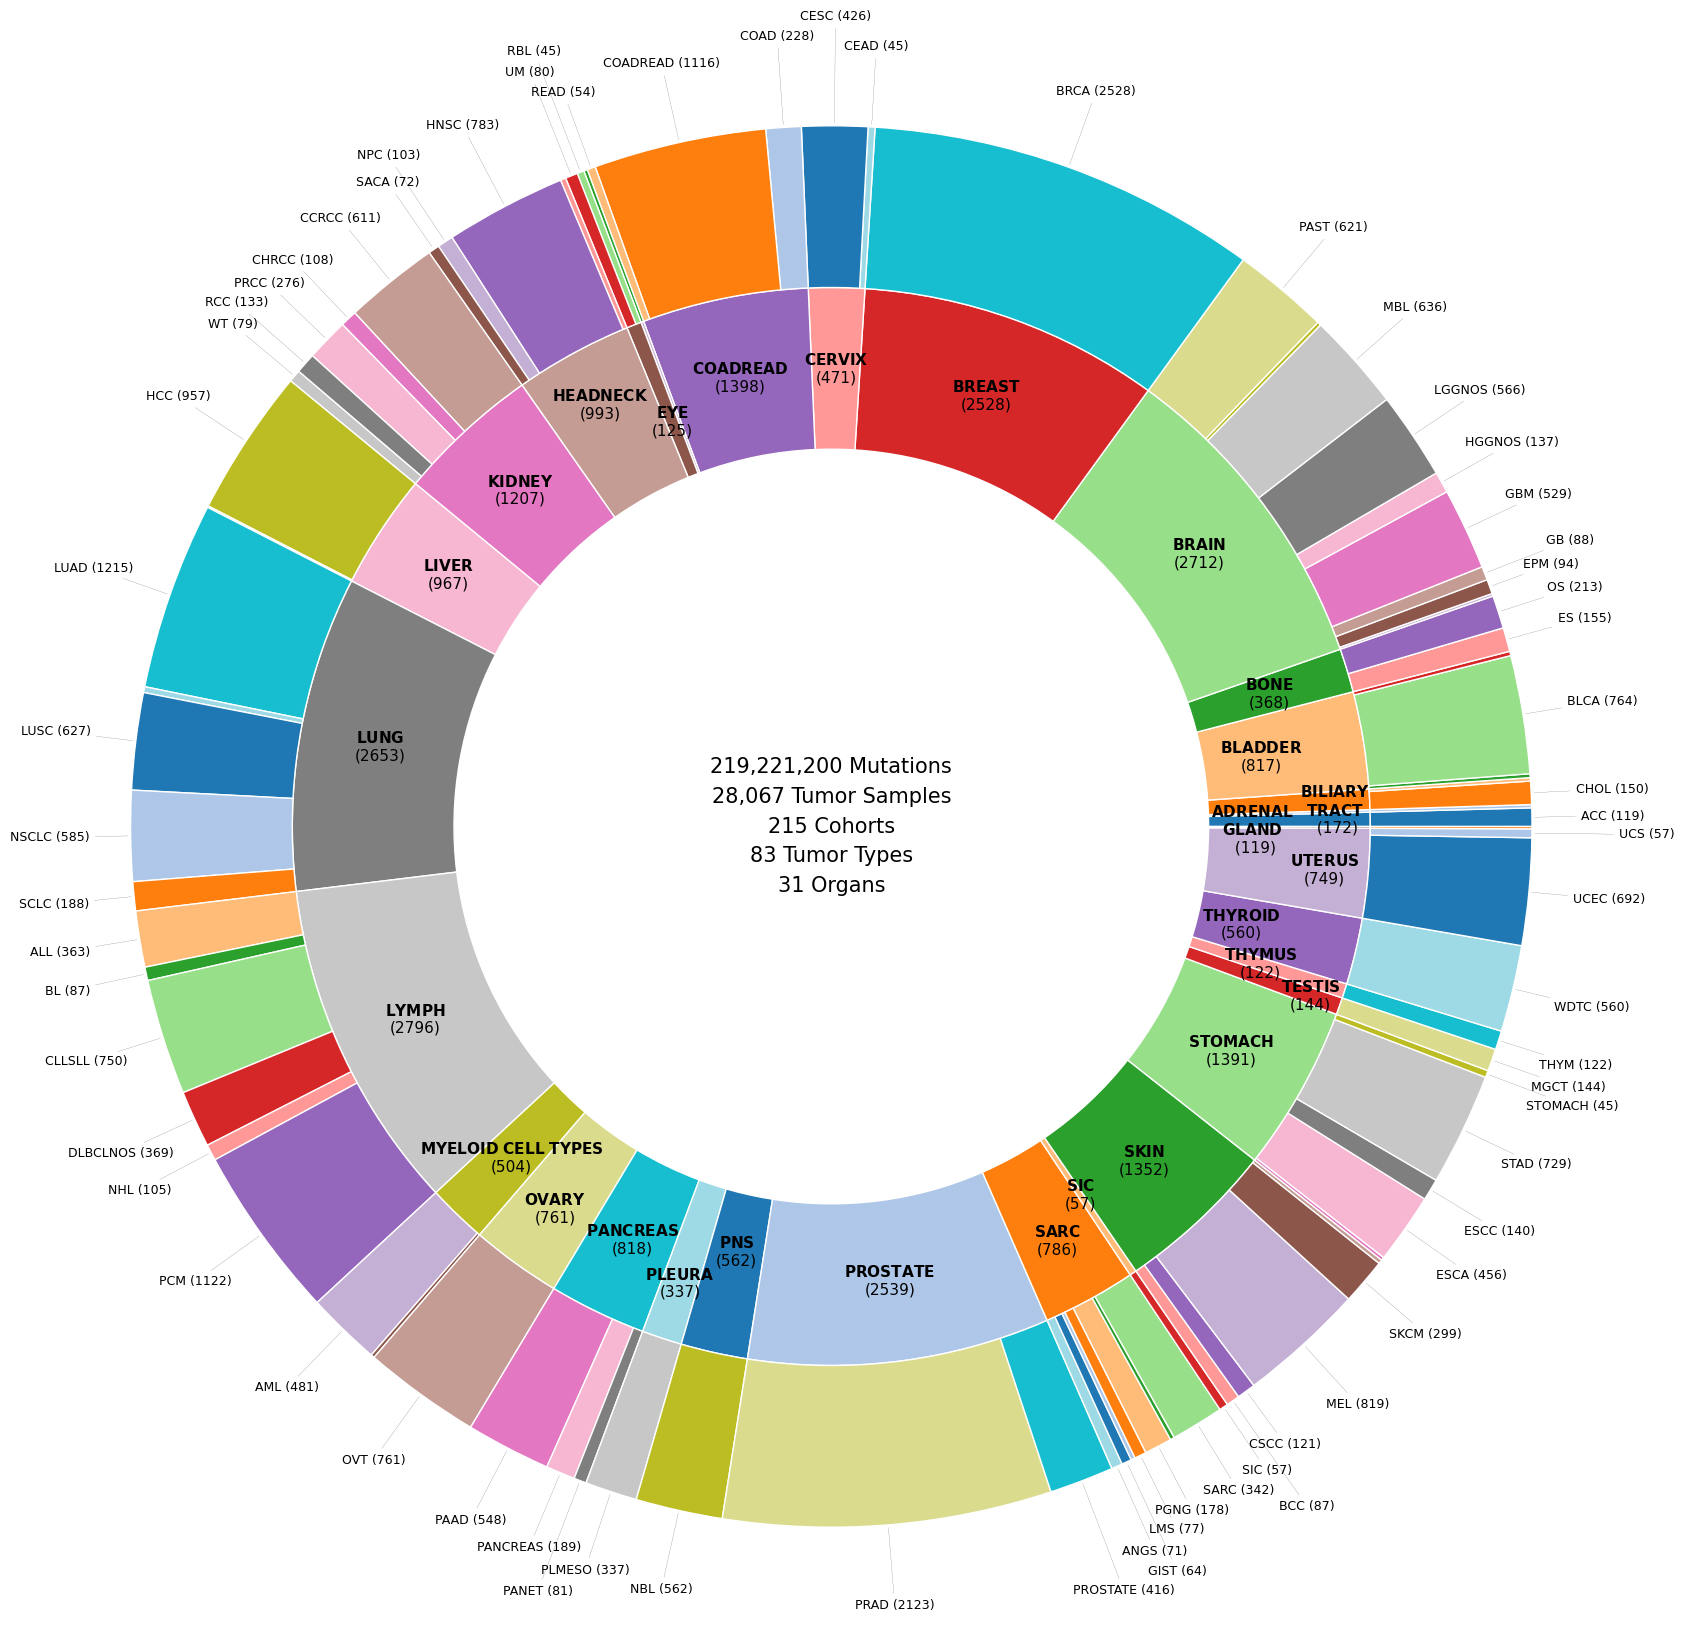

In [148]:
df = cohort_df.copy()

# Aggregate the samples for GENERAL_CANCER_TYPE and CANCER_TYPE_FULL
general_type_agg = df.groupby("GENERAL_CANCER_TYPE")["SAMPLES"].sum()
full_type_agg = df.groupby(["GENERAL_CANCER_TYPE", "CANCER_TYPE"])["SAMPLES"].sum()

colors = plt.cm.tab20.colors
fig, ax = plt.subplots(figsize=(21, 21))
size = 0.3  # Thickness of each ring

# Plot the inner ring
inner_sizes = general_type_agg.values
inner_labels = general_type_agg.index
wedges_inner, _ = ax.pie(inner_sizes, radius=1, labels=None, colors=colors[:len(inner_sizes)],
                         wedgeprops=dict(width=size, edgecolor='w'))

# Add labels
for wedge, label in zip(wedges_inner, inner_labels):
    sample_count = df[df["GENERAL_CANCER_TYPE"] == label].SAMPLES.sum()
    if sample_count < 40:
        continue
    if label in dict_pad_organ:
        pad = dict_pad_organ[label]
    else:
        pad = 1
    if label in ["BILIARY TRACT", "ADRENAL GLAND"]:
        txt = label.split(' ')
        label = "\n" + fr"$\bf{{{txt[0]}}}$" + "\n" + fr"$\bf{{{txt[1]}}}$" + "\n" + f" ({sample_count})"
    elif label in ["MYELOID CELL TYPES"]:
        txt = label.split(' ')
        label = fr"$\bf{{{txt[0]}}}$" + " " + fr"$\bf{{{txt[1]}}}$" + " " + fr"$\bf{{{txt[2]}}}$" + "\n" + f"({sample_count})"
    else:
        label = fr"$\bf{{{label}}}$" + f"\n({sample_count})"
    
    theta = (wedge.theta1 + wedge.theta2) / 2  # Angle in degrees
    x = 0.85 * np.cos(np.radians(theta)) * pad  
    y = 0.85 * np.sin(np.radians(theta)) * pad
    ax.text(x, y, label, ha="center", va="center", fontsize=11)

# Plot the outer ring 
outer_sizes = full_type_agg.values
outer_labels = full_type_agg.index.get_level_values(1)
wedges_outer, _ = ax.pie(outer_sizes, radius=1 + size, labels=None, colors=colors[:len(outer_sizes)],
                         wedgeprops=dict(width=size, edgecolor='w'))

# Add labels 
sp = 0.05
pad_out_txt = 1.4 + sp
for i, (wedge, label) in enumerate(zip(wedges_outer, outer_labels)):
    sample_count = df[df["CANCER_TYPE"] == label].SAMPLES.sum()
    if sample_count < 40:
        continue
    if label in dict_pad_cancer:
        pad = dict_pad_cancer[label] + sp
    else:
        pad = pad_out_txt 
    label = f"{label} ({sample_count})"
    theta = (wedge.theta1 + wedge.theta2) / 2  
    x_arrow = np.cos(np.radians(theta)) * pad 
    y_arrow = np.sin(np.radians(theta)) * pad
    x_start = np.cos(np.radians(theta)) * (1 + size) 
    y_start = np.sin(np.radians(theta)) * (1 + size)
    ax.annotate(label, xy=(x_start, y_start), xytext=(x_arrow, y_arrow),
                arrowprops=dict(arrowstyle="-", color="black", lw=0.1),
                ha="center", va="center", fontsize=9)

# Central annotation
mut = df.MUTATIONS.sum()
samples = df.SAMPLES.sum()
cohort_count = len(df.COHORT.unique())
cancer_type_count = len(df.CANCER_TYPE.unique())
organ_count = len(df.GENERAL_CANCER_TYPE.unique())
annot = f"{mut:,} Mutations\n{samples:,} Tumor Samples\n{cohort_count:,} Cohorts\n{cancer_type_count:,} Tumor Types\n{organ_count:,} Organs"
ax.text(0, 0, annot, ha="center", va="center", fontsize=15, linespacing=1.6)

# Avoid clipping
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

plt.savefig("data_visualization.png", dpi=300, bbox_inches='tight')
plt.show()